In [1]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
def Race(v, b, ndt=0, dt=0.001):
    x = np.array([0.0, 0.0])
    rt = 0
    ch = -1
    stop = False
    while not stop:
        x[0] += v[0]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[1] += v[1]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        rt += dt
        if x[0]>= b and x[1]<b:
            ch = 0.0
            stop = True
        elif x[1]>= b and x[0]<b:
            ch = 1.0
            stop = True
        elif x[0]>= b and x[0]>=b:
            rt = 0
            x = np.array([0.0, 0.0])
    return rt+ndt, ch

In [3]:
data_df = pd.read_csv('../../../_data/Yang2024.csv', index_col=0)

data_df['choice'] = data_df['choice'].map({1:0, 2:1})

min_rt = data_df.groupby(by='sbj')['rt'].min()
data_df['sbj'] -= 1

tr_df, ts_df = data_df.copy(), data_df.copy()

obs_train = np.asarray(data_df[['rt', 'Right', 'sbj']])
X_train = np.asarray(data_df[["o1_a1_val", "o1_a2_val", "o2_a1_val", "o2_a2_val",
                              "o1_a1_gaze", "o1_a2_gaze", "o2_a1_gaze", "o2_a2_gaze"]])

obs_test = np.asarray(data_df[['rt', 'Right', 'sbj']])
X_test = np.asarray(data_df[["o1_a1_val", "o1_a2_val", "o2_a1_val", "o2_a2_val",
                             "o1_a1_gaze", "o1_a2_gaze", "o2_a1_gaze", "o2_a2_gaze"]])

print(X_train.shape, X_test.shape)

(9731, 8) (9731, 8)


In [4]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)

def G2(data, pred):

    sbj_indices = tf.cast(data[:, 2], tf.int32)

    # Gather values directly using TensorFlow operations
    gathered_min_rt = tf.gather(min_rt, sbj_indices)
    sigmoid_weights = tf.gather(model.layers[-1].weights[-1], sbj_indices)
    ndt = gathered_min_rt * tf.math.sigmoid(sigmoid_weights)

    thr_weights = tf.gather(model.layers[-1].weights[-2], sbj_indices)
    thr = tf.math.log(1 + tf.exp(thr_weights))

    scl_weights = tf.gather(model.layers[-1].weights[-3], sbj_indices)
    scl = tf.math.log(1 + tf.exp(scl_weights))

    ll1 = (1 - data[:, 1]) * fpt(data[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(data[:, 0]-ndt, thr, scl*pred[:, 1]))
    ll2 = (data[:, 1]) * fpt(data[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(data[:, 0]-ndt, thr, scl*pred[:, 0]))

    return -2*tf.reduce_sum(tf.math.log(ll1 + ll2 + 0.1**14), axis=-1)

In [5]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=2, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [6]:
layers_neuron = [10, 10, 8, 5]
input_shape = 8
output_shape = 2
activation = 'tanh'
n_sbj = data_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                90        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 8)                 88        
                                                                 
 dense_3 (Dense)             (None, 5)                 45        
                                                                 
 out_layer (Out_layer)       (None, 2)                 96        
                                                                 
Total params: 429 (1.68 KB)
Trainable params: 429 (1.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [7]:
sbj_indices = tf.cast(obs_train[:, 2], tf.int32)
obs_train = tf.cast(obs_train, tf.float32)
X_train = tf.convert_to_tensor(X_train)
X_train = tf.cast(X_train, tf.float32)

min_rt = tf.convert_to_tensor(min_rt)
min_rt = tf.cast(min_rt, tf.float32)

In [8]:
history = model.fit(X_train, 
                    obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=2500)

Epoch 1/2500
1/1 [==============================] - 2s 2s/step - loss: 45968.5938
Epoch 2/2500
1/1 [==============================] - 0s 19ms/step - loss: 45770.2422
Epoch 3/2500
1/1 [==============================] - 0s 9ms/step - loss: 45625.4727
Epoch 4/2500
1/1 [==============================] - 0s 9ms/step - loss: 45503.4531
Epoch 5/2500
1/1 [==============================] - 0s 8ms/step - loss: 45394.3594
Epoch 6/2500
1/1 [==============================] - 0s 9ms/step - loss: 45293.7656
Epoch 7/2500
1/1 [==============================] - 0s 9ms/step - loss: 45199.3203
Epoch 8/2500
1/1 [==============================] - 0s 10ms/step - loss: 45109.6016
Epoch 9/2500
1/1 [==============================] - 0s 9ms/step - loss: 45023.6875
Epoch 10/2500
1/1 [==============================] - 0s 9ms/step - loss: 44940.9453
Epoch 11/2500
1/1 [==============================] - 0s 9ms/step - loss: 44860.9023
Epoch 12/2500
1/1 [==============================] - 0s 33ms/step - loss: 44783.2109

1/1 [==============================] - 0s 13ms/step - loss: 40759.6953
Epoch 98/2500
1/1 [==============================] - 0s 15ms/step - loss: 40726.3516
Epoch 99/2500
1/1 [==============================] - 0s 14ms/step - loss: 40693.2148
Epoch 100/2500
1/1 [==============================] - 0s 13ms/step - loss: 40660.2578
Epoch 101/2500
1/1 [==============================] - 0s 13ms/step - loss: 40627.4961
Epoch 102/2500
1/1 [==============================] - 0s 10ms/step - loss: 40594.9180
Epoch 103/2500
1/1 [==============================] - 0s 11ms/step - loss: 40562.5195
Epoch 104/2500
1/1 [==============================] - 0s 11ms/step - loss: 40530.3125
Epoch 105/2500
1/1 [==============================] - 0s 11ms/step - loss: 40498.2812
Epoch 106/2500
1/1 [==============================] - 0s 11ms/step - loss: 40466.4297
Epoch 107/2500
1/1 [==============================] - 0s 10ms/step - loss: 40434.7578
Epoch 108/2500
1/1 [==============================] - 0s 12ms/step - lo

1/1 [==============================] - 0s 12ms/step - loss: 38233.9375
Epoch 193/2500
1/1 [==============================] - 0s 11ms/step - loss: 38212.3828
Epoch 194/2500
1/1 [==============================] - 0s 12ms/step - loss: 38190.9062
Epoch 195/2500
1/1 [==============================] - 0s 10ms/step - loss: 38169.5000
Epoch 196/2500
1/1 [==============================] - 0s 12ms/step - loss: 38148.1680
Epoch 197/2500
1/1 [==============================] - 0s 12ms/step - loss: 38126.9062
Epoch 198/2500
1/1 [==============================] - 0s 12ms/step - loss: 38105.7188
Epoch 199/2500
1/1 [==============================] - 0s 13ms/step - loss: 38084.5977
Epoch 200/2500
1/1 [==============================] - 0s 11ms/step - loss: 38063.5469
Epoch 201/2500
1/1 [==============================] - 0s 11ms/step - loss: 38042.5625
Epoch 202/2500
1/1 [==============================] - 0s 11ms/step - loss: 38021.6406
Epoch 203/2500
1/1 [==============================] - 0s 11ms/step - 

1/1 [==============================] - 0s 11ms/step - loss: 36197.1406
Epoch 288/2500
1/1 [==============================] - 0s 9ms/step - loss: 36168.0234
Epoch 289/2500
1/1 [==============================] - 0s 10ms/step - loss: 36139.0977
Epoch 290/2500
1/1 [==============================] - 0s 10ms/step - loss: 36110.3164
Epoch 291/2500
1/1 [==============================] - 0s 9ms/step - loss: 36081.6641
Epoch 292/2500
1/1 [==============================] - 0s 10ms/step - loss: 36053.1211
Epoch 293/2500
1/1 [==============================] - 0s 11ms/step - loss: 36024.6758
Epoch 294/2500
1/1 [==============================] - 0s 11ms/step - loss: 35996.3242
Epoch 295/2500
1/1 [==============================] - 0s 11ms/step - loss: 35968.0625
Epoch 296/2500
1/1 [==============================] - 0s 11ms/step - loss: 35939.8789
Epoch 297/2500
1/1 [==============================] - 0s 10ms/step - loss: 35911.7812
Epoch 298/2500
1/1 [==============================] - 0s 11ms/step - lo

1/1 [==============================] - 0s 14ms/step - loss: 33454.6133
Epoch 383/2500
1/1 [==============================] - 0s 10ms/step - loss: 33426.1094
Epoch 384/2500
1/1 [==============================] - 0s 10ms/step - loss: 33397.5234
Epoch 385/2500
1/1 [==============================] - 0s 10ms/step - loss: 33368.9336
Epoch 386/2500
1/1 [==============================] - 0s 10ms/step - loss: 33340.3438
Epoch 387/2500
1/1 [==============================] - 0s 10ms/step - loss: 33311.7734
Epoch 388/2500
1/1 [==============================] - 0s 10ms/step - loss: 33283.1992
Epoch 389/2500
1/1 [==============================] - 0s 10ms/step - loss: 33254.6172
Epoch 390/2500
1/1 [==============================] - 0s 10ms/step - loss: 33226.0117
Epoch 391/2500
1/1 [==============================] - 0s 10ms/step - loss: 33197.3828
Epoch 392/2500
1/1 [==============================] - 0s 10ms/step - loss: 33168.7344
Epoch 393/2500
1/1 [==============================] - 0s 15ms/step - 

1/1 [==============================] - 0s 18ms/step - loss: 30416.4531
Epoch 478/2500
1/1 [==============================] - 0s 18ms/step - loss: 30387.8594
Epoch 479/2500
1/1 [==============================] - 0s 22ms/step - loss: 30359.7812
Epoch 480/2500
1/1 [==============================] - 0s 20ms/step - loss: 30331.3398
Epoch 481/2500
1/1 [==============================] - 0s 19ms/step - loss: 30303.4316
Epoch 482/2500
1/1 [==============================] - 0s 17ms/step - loss: 30275.1504
Epoch 483/2500
1/1 [==============================] - 0s 20ms/step - loss: 30247.4082
Epoch 484/2500
1/1 [==============================] - 0s 12ms/step - loss: 30219.2754
Epoch 485/2500
1/1 [==============================] - 0s 11ms/step - loss: 30191.6992
Epoch 486/2500
1/1 [==============================] - 0s 12ms/step - loss: 30163.7168
Epoch 487/2500
1/1 [==============================] - 0s 12ms/step - loss: 30136.2988
Epoch 488/2500
1/1 [==============================] - 0s 12ms/step - 

1/1 [==============================] - 0s 10ms/step - loss: 28057.5273
Epoch 573/2500
1/1 [==============================] - 0s 11ms/step - loss: 28036.4961
Epoch 574/2500
1/1 [==============================] - 0s 11ms/step - loss: 28014.6035
Epoch 575/2500
1/1 [==============================] - 0s 32ms/step - loss: 27993.6953
Epoch 576/2500
1/1 [==============================] - 0s 32ms/step - loss: 27971.9199
Epoch 577/2500
1/1 [==============================] - 0s 29ms/step - loss: 27951.1367
Epoch 578/2500
1/1 [==============================] - 0s 33ms/step - loss: 27929.4766
Epoch 579/2500
1/1 [==============================] - 0s 28ms/step - loss: 27908.8184
Epoch 580/2500
1/1 [==============================] - 0s 26ms/step - loss: 27887.2754
Epoch 581/2500
1/1 [==============================] - 0s 27ms/step - loss: 27866.7383
Epoch 582/2500
1/1 [==============================] - 0s 27ms/step - loss: 27845.3066
Epoch 583/2500
1/1 [==============================] - 0s 14ms/step - 

1/1 [==============================] - 0s 12ms/step - loss: 26256.4844
Epoch 668/2500
1/1 [==============================] - 0s 40ms/step - loss: 26239.1602
Epoch 669/2500
1/1 [==============================] - 0s 44ms/step - loss: 26223.0977
Epoch 670/2500
1/1 [==============================] - 0s 38ms/step - loss: 26205.8516
Epoch 671/2500
1/1 [==============================] - 0s 13ms/step - loss: 26189.8711
Epoch 672/2500
1/1 [==============================] - 0s 14ms/step - loss: 26172.6973
Epoch 673/2500
1/1 [==============================] - 0s 11ms/step - loss: 26156.7988
Epoch 674/2500
1/1 [==============================] - 0s 15ms/step - loss: 26139.7012
Epoch 675/2500
1/1 [==============================] - 0s 20ms/step - loss: 26123.8828
Epoch 676/2500
1/1 [==============================] - 0s 14ms/step - loss: 26106.8574
Epoch 677/2500
1/1 [==============================] - 0s 12ms/step - loss: 26091.1172
Epoch 678/2500
1/1 [==============================] - 0s 40ms/step - 

1/1 [==============================] - 0s 24ms/step - loss: 24828.5234
Epoch 763/2500
1/1 [==============================] - 0s 21ms/step - loss: 24815.7715
Epoch 764/2500
1/1 [==============================] - 0s 17ms/step - loss: 24801.6426
Epoch 765/2500
1/1 [==============================] - 0s 16ms/step - loss: 24788.9492
Epoch 766/2500
1/1 [==============================] - 0s 14ms/step - loss: 24774.8809
Epoch 767/2500
1/1 [==============================] - 0s 10ms/step - loss: 24762.2441
Epoch 768/2500
1/1 [==============================] - 0s 11ms/step - loss: 24748.2344
Epoch 769/2500
1/1 [==============================] - 0s 10ms/step - loss: 24735.6562
Epoch 770/2500
1/1 [==============================] - 0s 10ms/step - loss: 24721.7070
Epoch 771/2500
1/1 [==============================] - 0s 10ms/step - loss: 24709.1875
Epoch 772/2500
1/1 [==============================] - 0s 11ms/step - loss: 24695.2930
Epoch 773/2500
1/1 [==============================] - 0s 11ms/step - 

1/1 [==============================] - 0s 17ms/step - loss: 23672.1484
Epoch 858/2500
1/1 [==============================] - 0s 16ms/step - loss: 23660.3418
Epoch 859/2500
1/1 [==============================] - 0s 15ms/step - loss: 23650.1406
Epoch 860/2500
1/1 [==============================] - 0s 15ms/step - loss: 23638.3711
Epoch 861/2500
1/1 [==============================] - 0s 19ms/step - loss: 23628.2129
Epoch 862/2500
1/1 [==============================] - 0s 15ms/step - loss: 23616.4844
Epoch 863/2500
1/1 [==============================] - 0s 16ms/step - loss: 23606.3711
Epoch 864/2500
1/1 [==============================] - 0s 17ms/step - loss: 23594.6680
Epoch 865/2500
1/1 [==============================] - 0s 17ms/step - loss: 23584.5957
Epoch 866/2500
1/1 [==============================] - 0s 18ms/step - loss: 23572.9434
Epoch 867/2500
1/1 [==============================] - 0s 16ms/step - loss: 23562.9102
Epoch 868/2500
1/1 [==============================] - 0s 16ms/step - 

1/1 [==============================] - 0s 11ms/step - loss: 22702.9258
Epoch 953/2500
1/1 [==============================] - 0s 11ms/step - loss: 22694.4453
Epoch 954/2500
1/1 [==============================] - 0s 10ms/step - loss: 22683.9355
Epoch 955/2500
1/1 [==============================] - 0s 10ms/step - loss: 22675.4883
Epoch 956/2500
1/1 [==============================] - 0s 10ms/step - loss: 22664.9824
Epoch 957/2500
1/1 [==============================] - 0s 11ms/step - loss: 22656.5664
Epoch 958/2500
1/1 [==============================] - 0s 11ms/step - loss: 22646.0820
Epoch 959/2500
1/1 [==============================] - 0s 10ms/step - loss: 22637.6992
Epoch 960/2500
1/1 [==============================] - 0s 11ms/step - loss: 22627.2344
Epoch 961/2500
1/1 [==============================] - 0s 10ms/step - loss: 22618.8828
Epoch 962/2500
1/1 [==============================] - 0s 10ms/step - loss: 22608.4277
Epoch 963/2500
1/1 [==============================] - 0s 10ms/step - 

Epoch 1047/2500
1/1 [==============================] - 0s 11ms/step - loss: 21844.9727
Epoch 1048/2500
1/1 [==============================] - 0s 11ms/step - loss: 21834.8242
Epoch 1049/2500
1/1 [==============================] - 0s 15ms/step - loss: 21827.7188
Epoch 1050/2500
1/1 [==============================] - 0s 17ms/step - loss: 21817.5645
Epoch 1051/2500
1/1 [==============================] - 0s 16ms/step - loss: 21810.4883
Epoch 1052/2500
1/1 [==============================] - 0s 14ms/step - loss: 21800.3359
Epoch 1053/2500
1/1 [==============================] - 0s 14ms/step - loss: 21793.2891
Epoch 1054/2500
1/1 [==============================] - 0s 15ms/step - loss: 21783.1445
Epoch 1055/2500
1/1 [==============================] - 0s 16ms/step - loss: 21776.1211
Epoch 1056/2500
1/1 [==============================] - 0s 14ms/step - loss: 21765.9785
Epoch 1057/2500
1/1 [==============================] - 0s 11ms/step - loss: 21758.9883
Epoch 1058/2500
1/1 [======================

1/1 [==============================] - 0s 14ms/step - loss: 21056.6367
Epoch 1142/2500
1/1 [==============================] - 0s 13ms/step - loss: 21046.1875
Epoch 1143/2500
1/1 [==============================] - 0s 14ms/step - loss: 21040.1445
Epoch 1144/2500
1/1 [==============================] - 0s 15ms/step - loss: 21029.6738
Epoch 1145/2500
1/1 [==============================] - 0s 13ms/step - loss: 21023.6484
Epoch 1146/2500
1/1 [==============================] - 0s 15ms/step - loss: 21013.1289
Epoch 1147/2500
1/1 [==============================] - 0s 18ms/step - loss: 21007.0801
Epoch 1148/2500
1/1 [==============================] - 0s 10ms/step - loss: 20996.5078
Epoch 1149/2500
1/1 [==============================] - 0s 11ms/step - loss: 20990.4805
Epoch 1150/2500
1/1 [==============================] - 0s 12ms/step - loss: 20979.9102
Epoch 1151/2500
1/1 [==============================] - 0s 13ms/step - loss: 20973.9492
Epoch 1152/2500
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 10ms/step - loss: 20271.0547
Epoch 1236/2500
1/1 [==============================] - 0s 10ms/step - loss: 20264.5742
Epoch 1237/2500
1/1 [==============================] - 0s 12ms/step - loss: 20261.0156
Epoch 1238/2500
1/1 [==============================] - 0s 11ms/step - loss: 20249.7422
Epoch 1239/2500
1/1 [==============================] - 0s 12ms/step - loss: 20236.6719
Epoch 1240/2500
1/1 [==============================] - 0s 10ms/step - loss: 20222.6465
Epoch 1241/2500
1/1 [==============================] - 0s 10ms/step - loss: 20212.9844
Epoch 1242/2500
1/1 [==============================] - 0s 11ms/step - loss: 20204.1445
Epoch 1243/2500
1/1 [==============================] - 0s 12ms/step - loss: 20199.7910
Epoch 1244/2500
1/1 [==============================] - 0s 28ms/step - loss: 20194.3926
Epoch 1245/2500
1/1 [==============================] - 0s 28ms/step - loss: 20193.6016
Epoch 1246/2500
1/1 [==============================] - 0s 3

1/1 [==============================] - 0s 19ms/step - loss: 19587.0176
Epoch 1330/2500
1/1 [==============================] - 0s 18ms/step - loss: 19577.7949
Epoch 1331/2500
1/1 [==============================] - 0s 22ms/step - loss: 19574.0273
Epoch 1332/2500
1/1 [==============================] - 0s 16ms/step - loss: 19565.1602
Epoch 1333/2500
1/1 [==============================] - 0s 20ms/step - loss: 19561.8164
Epoch 1334/2500
1/1 [==============================] - 0s 28ms/step - loss: 19552.3359
Epoch 1335/2500
1/1 [==============================] - 0s 29ms/step - loss: 19548.9258
Epoch 1336/2500
1/1 [==============================] - 0s 29ms/step - loss: 19539.6172
Epoch 1337/2500
1/1 [==============================] - 0s 19ms/step - loss: 19535.9727
Epoch 1338/2500
1/1 [==============================] - 0s 12ms/step - loss: 19526.5645
Epoch 1339/2500
1/1 [==============================] - 0s 10ms/step - loss: 19522.9102
Epoch 1340/2500
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 19ms/step - loss: 19027.8711
Epoch 1424/2500
1/1 [==============================] - 0s 17ms/step - loss: 19018.1055
Epoch 1425/2500
1/1 [==============================] - 0s 19ms/step - loss: 19018.3672
Epoch 1426/2500
1/1 [==============================] - 0s 17ms/step - loss: 19007.3965
Epoch 1427/2500
1/1 [==============================] - 0s 16ms/step - loss: 19007.0703
Epoch 1428/2500
1/1 [==============================] - 0s 18ms/step - loss: 18996.5449
Epoch 1429/2500
1/1 [==============================] - 0s 17ms/step - loss: 18996.1953
Epoch 1430/2500
1/1 [==============================] - 0s 27ms/step - loss: 18986.2480
Epoch 1431/2500
1/1 [==============================] - 0s 42ms/step - loss: 18985.8945
Epoch 1432/2500
1/1 [==============================] - 0s 14ms/step - loss: 18975.2754
Epoch 1433/2500
1/1 [==============================] - 0s 15ms/step - loss: 18975.0391
Epoch 1434/2500
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 12ms/step - loss: 18564.8223
Epoch 1518/2500
1/1 [==============================] - 0s 11ms/step - loss: 18550.6914
Epoch 1519/2500
1/1 [==============================] - 0s 11ms/step - loss: 18552.4531
Epoch 1520/2500
1/1 [==============================] - 0s 12ms/step - loss: 18538.0820
Epoch 1521/2500
1/1 [==============================] - 0s 13ms/step - loss: 18541.4570
Epoch 1522/2500
1/1 [==============================] - 0s 17ms/step - loss: 18528.7109
Epoch 1523/2500
1/1 [==============================] - 0s 17ms/step - loss: 18532.8105
Epoch 1524/2500
1/1 [==============================] - 0s 26ms/step - loss: 18523.0508
Epoch 1525/2500
1/1 [==============================] - 0s 17ms/step - loss: 18527.9062
Epoch 1526/2500
1/1 [==============================] - 0s 19ms/step - loss: 18517.2188
Epoch 1527/2500
1/1 [==============================] - 0s 16ms/step - loss: 18521.7539
Epoch 1528/2500
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 10ms/step - loss: nan
Epoch 1613/2500
1/1 [==============================] - 0s 9ms/step - loss: 18148.0098
Epoch 1614/2500
1/1 [==============================] - 0s 10ms/step - loss: 18155.7461
Epoch 1615/2500
1/1 [==============================] - 0s 10ms/step - loss: 18196.1992
Epoch 1616/2500
1/1 [==============================] - 0s 10ms/step - loss: nan
Epoch 1617/2500
1/1 [==============================] - 0s 9ms/step - loss: 18178.5156
Epoch 1618/2500
1/1 [==============================] - 0s 10ms/step - loss: nan
Epoch 1619/2500
1/1 [==============================] - 0s 10ms/step - loss: 18991.8730
Epoch 1620/2500
1/1 [==============================] - 0s 11ms/step - loss: 18321.8477
Epoch 1621/2500
1/1 [==============================] - 0s 11ms/step - loss: 18176.1836
Epoch 1622/2500
1/1 [==============================] - 0s 10ms/step - loss: 18101.7500
Epoch 1623/2500
1/1 [==============================] - 0s 10ms/step - loss: 18062.

1/1 [==============================] - 0s 12ms/step - loss: 17850.7031
Epoch 1708/2500
1/1 [==============================] - 0s 12ms/step - loss: nan
Epoch 1709/2500
1/1 [==============================] - 0s 12ms/step - loss: 17832.7695
Epoch 1710/2500
1/1 [==============================] - 0s 11ms/step - loss: 17832.4453
Epoch 1711/2500
1/1 [==============================] - 0s 12ms/step - loss: 17855.7461
Epoch 1712/2500
1/1 [==============================] - 0s 11ms/step - loss: 17865.3594
Epoch 1713/2500
1/1 [==============================] - 0s 12ms/step - loss: 17945.1289
Epoch 1714/2500
1/1 [==============================] - 0s 12ms/step - loss: nan
Epoch 1715/2500
1/1 [==============================] - 0s 11ms/step - loss: 17904.8867
Epoch 1716/2500
1/1 [==============================] - 0s 13ms/step - loss: 17859.2207
Epoch 1717/2500
1/1 [==============================] - 0s 13ms/step - loss: 17856.0273
Epoch 1718/2500
1/1 [==============================] - 0s 12ms/step - los

1/1 [==============================] - 0s 14ms/step - loss: 17971.6562
Epoch 1805/2500
1/1 [==============================] - 0s 12ms/step - loss: 17970.5820
Epoch 1806/2500
1/1 [==============================] - 0s 12ms/step - loss: 17963.9258
Epoch 1807/2500
1/1 [==============================] - 0s 13ms/step - loss: 17959.9922
Epoch 1808/2500
1/1 [==============================] - 0s 10ms/step - loss: 17956.2656
Epoch 1809/2500
1/1 [==============================] - 0s 12ms/step - loss: nan
Epoch 1810/2500
1/1 [==============================] - 0s 12ms/step - loss: nan
Epoch 1811/2500
1/1 [==============================] - 0s 10ms/step - loss: 17945.6211
Epoch 1812/2500
1/1 [==============================] - 0s 12ms/step - loss: 17947.5625
Epoch 1813/2500
1/1 [==============================] - 0s 11ms/step - loss: 17939.6875
Epoch 1814/2500
1/1 [==============================] - 0s 10ms/step - loss: 17939.1973
Epoch 1815/2500
1/1 [==============================] - 0s 13ms/step - los

1/1 [==============================] - 0s 14ms/step - loss: 17736.9375
Epoch 1900/2500
1/1 [==============================] - 0s 9ms/step - loss: nan
Epoch 1901/2500
1/1 [==============================] - 0s 11ms/step - loss: 17731.9785
Epoch 1902/2500
1/1 [==============================] - 0s 11ms/step - loss: 17729.4180
Epoch 1903/2500
1/1 [==============================] - 0s 11ms/step - loss: 17728.7109
Epoch 1904/2500
1/1 [==============================] - 0s 12ms/step - loss: 17723.9141
Epoch 1905/2500
1/1 [==============================] - 0s 11ms/step - loss: 17724.3984
Epoch 1906/2500
1/1 [==============================] - 0s 11ms/step - loss: 17719.2695
Epoch 1907/2500
1/1 [==============================] - 0s 12ms/step - loss: 17719.4004
Epoch 1908/2500
1/1 [==============================] - 0s 11ms/step - loss: nan
Epoch 1909/2500
1/1 [==============================] - 0s 11ms/step - loss: 17714.2480
Epoch 1910/2500
1/1 [==============================] - 0s 9ms/step - loss:

1/1 [==============================] - 0s 39ms/step - loss: 17450.6211
Epoch 1995/2500
1/1 [==============================] - 0s 35ms/step - loss: 17446.2461
Epoch 1996/2500
1/1 [==============================] - 0s 36ms/step - loss: 17435.5820
Epoch 1997/2500
1/1 [==============================] - 0s 54ms/step - loss: 17440.0820
Epoch 1998/2500
1/1 [==============================] - 0s 43ms/step - loss: 17431.4922
Epoch 1999/2500
1/1 [==============================] - 0s 21ms/step - loss: 17431.0762
Epoch 2000/2500
1/1 [==============================] - 0s 23ms/step - loss: 17432.4473
Epoch 2001/2500
1/1 [==============================] - 0s 22ms/step - loss: 17417.4336
Epoch 2002/2500
1/1 [==============================] - 0s 24ms/step - loss: 17411.4570
Epoch 2003/2500
1/1 [==============================] - 0s 21ms/step - loss: 17408.9668
Epoch 2004/2500
1/1 [==============================] - 0s 22ms/step - loss: 17403.9844
Epoch 2005/2500
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 30ms/step - loss: 17273.7012
Epoch 2093/2500
1/1 [==============================] - 0s 21ms/step - loss: 18182.9766
Epoch 2094/2500
1/1 [==============================] - 0s 19ms/step - loss: 17351.2871
Epoch 2095/2500
1/1 [==============================] - 0s 14ms/step - loss: nan
Epoch 2096/2500
1/1 [==============================] - 0s 11ms/step - loss: 17202.3555
Epoch 2097/2500
1/1 [==============================] - 0s 12ms/step - loss: nan
Epoch 2098/2500
1/1 [==============================] - 0s 11ms/step - loss: 17195.6680
Epoch 2099/2500
1/1 [==============================] - 0s 11ms/step - loss: nan
Epoch 2100/2500
1/1 [==============================] - 0s 11ms/step - loss: 17180.8906
Epoch 2101/2500
1/1 [==============================] - 0s 10ms/step - loss: nan
Epoch 2102/2500
1/1 [==============================] - 0s 11ms/step - loss: nan
Epoch 2103/2500
1/1 [==============================] - 0s 11ms/step - loss: nan
Epoch 2104/250

1/1 [==============================] - 0s 15ms/step - loss: 17079.1289
Epoch 2192/2500
1/1 [==============================] - 0s 11ms/step - loss: nan
Epoch 2193/2500
1/1 [==============================] - 0s 12ms/step - loss: nan
Epoch 2194/2500
1/1 [==============================] - 0s 10ms/step - loss: 17660.7930
Epoch 2195/2500
1/1 [==============================] - 0s 10ms/step - loss: nan
Epoch 2196/2500
1/1 [==============================] - 0s 11ms/step - loss: nan
Epoch 2197/2500
1/1 [==============================] - 0s 10ms/step - loss: nan
Epoch 2198/2500
1/1 [==============================] - 0s 11ms/step - loss: nan
Epoch 2199/2500
1/1 [==============================] - 0s 10ms/step - loss: nan
Epoch 2200/2500
1/1 [==============================] - 0s 11ms/step - loss: 17011.0566
Epoch 2201/2500
1/1 [==============================] - 0s 10ms/step - loss: nan
Epoch 2202/2500
1/1 [==============================] - 0s 12ms/step - loss: 16990.2812
Epoch 2203/2500
1/1 [=======

1/1 [==============================] - 0s 11ms/step - loss: nan
Epoch 2290/2500
1/1 [==============================] - 0s 10ms/step - loss: 16924.3984
Epoch 2291/2500
1/1 [==============================] - 0s 11ms/step - loss: nan
Epoch 2292/2500
1/1 [==============================] - 0s 12ms/step - loss: 16959.4336
Epoch 2293/2500
1/1 [==============================] - 0s 13ms/step - loss: nan
Epoch 2294/2500
1/1 [==============================] - 0s 24ms/step - loss: 17134.4316
Epoch 2295/2500
1/1 [==============================] - 0s 25ms/step - loss: nan
Epoch 2296/2500
1/1 [==============================] - 0s 17ms/step - loss: 17289.8086
Epoch 2297/2500
1/1 [==============================] - 0s 16ms/step - loss: nan
Epoch 2298/2500
1/1 [==============================] - 0s 15ms/step - loss: nan
Epoch 2299/2500
1/1 [==============================] - 0s 23ms/step - loss: nan
Epoch 2300/2500
1/1 [==============================] - 0s 15ms/step - loss: 17004.4414
Epoch 2301/2500
1/1 [

1/1 [==============================] - 0s 10ms/step - loss: nan
Epoch 2389/2500
1/1 [==============================] - 0s 12ms/step - loss: 17290.9688
Epoch 2390/2500
1/1 [==============================] - 0s 10ms/step - loss: nan
Epoch 2391/2500
1/1 [==============================] - 0s 11ms/step - loss: 17357.7617
Epoch 2392/2500
1/1 [==============================] - 0s 11ms/step - loss: nan
Epoch 2393/2500
1/1 [==============================] - 0s 13ms/step - loss: 16913.0469
Epoch 2394/2500
1/1 [==============================] - 0s 15ms/step - loss: nan
Epoch 2395/2500
1/1 [==============================] - 0s 26ms/step - loss: 16791.2285
Epoch 2396/2500
1/1 [==============================] - 0s 51ms/step - loss: 16755.0078
Epoch 2397/2500
1/1 [==============================] - 0s 26ms/step - loss: nan
Epoch 2398/2500
1/1 [==============================] - 0s 10ms/step - loss: 16733.9688
Epoch 2399/2500
1/1 [==============================] - 0s 10ms/step - loss: nan
Epoch 2400/250

1/1 [==============================] - 0s 13ms/step - loss: 17050.7656
Epoch 2486/2500
1/1 [==============================] - 0s 11ms/step - loss: nan
Epoch 2487/2500
1/1 [==============================] - 0s 12ms/step - loss: 16787.5664
Epoch 2488/2500
1/1 [==============================] - 0s 11ms/step - loss: nan
Epoch 2489/2500
1/1 [==============================] - 0s 13ms/step - loss: 16723.9844
Epoch 2490/2500
1/1 [==============================] - 0s 12ms/step - loss: nan
Epoch 2491/2500
1/1 [==============================] - 0s 15ms/step - loss: 16838.8672
Epoch 2492/2500
1/1 [==============================] - 0s 12ms/step - loss: nan
Epoch 2493/2500
1/1 [==============================] - 0s 11ms/step - loss: nan
Epoch 2494/2500
1/1 [==============================] - 0s 15ms/step - loss: nan
Epoch 2495/2500
1/1 [==============================] - 0s 14ms/step - loss: 16822.4844
Epoch 2496/2500
1/1 [==============================] - 0s 23ms/step - loss: nan
Epoch 2497/2500
1/1 [

In [9]:
pred_v = model.predict(X_test)
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))

305/305 [==============================] - 0s 993us/step


In [10]:
pred_bhv = {'sbj': [],
            'rt': [],
            'ch': [],
            'value_diff': [],
            'gaze_diff': []}

scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i-1] for i in ts_df['sbj']])

for n in range(10):
    for s in range(ts_df.shape[0]):
        rt, ch = Race(scaling[s]*pred_v[s,:], threshold[ts_df.sbj[s]-1], ndt[ts_df.sbj[s]-1])
        pred_bhv['sbj'].append(ts_df.sbj[s])
        pred_bhv['rt'].append(rt)
        pred_bhv['ch'].append(ch)
        pred_bhv['value_diff'].append(ts_df['Right Value - Left Value'][s])
        pred_bhv['gaze_diff'].append(ts_df['Dwell Time Advantage (R - L)'][s])
        
pred_bhv = pd.DataFrame(pred_bhv)

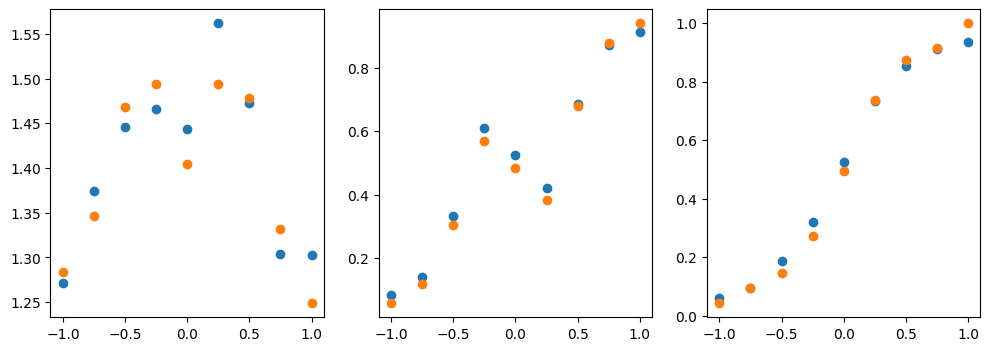

In [11]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(x=pred_bhv.groupby(by='value_diff')['value_diff'].mean(), y=pred_bhv.groupby(by='value_diff')['rt'].mean());
plt.scatter(x=ts_df.groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Left Value')['rt'].mean());

plt.subplot(132)
plt.scatter(x=pred_bhv.groupby(by='value_diff')['value_diff'].mean(), y=pred_bhv.groupby(by='value_diff')['ch'].mean());
plt.scatter(x=ts_df.groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Left Value')['choice'].mean());

plt.subplot(133)
plt.scatter(x=pred_bhv.groupby(by='gaze_diff')['gaze_diff'].mean(), y=pred_bhv.groupby(by='gaze_diff')['ch'].mean());
plt.scatter(x=ts_df.groupby(by='Dwell Time Advantage (R - L)')['Dwell Time Advantage (R - L)'].mean(), 
            y=ts_df.groupby(by='Dwell Time Advantage (R - L)')['choice'].mean());

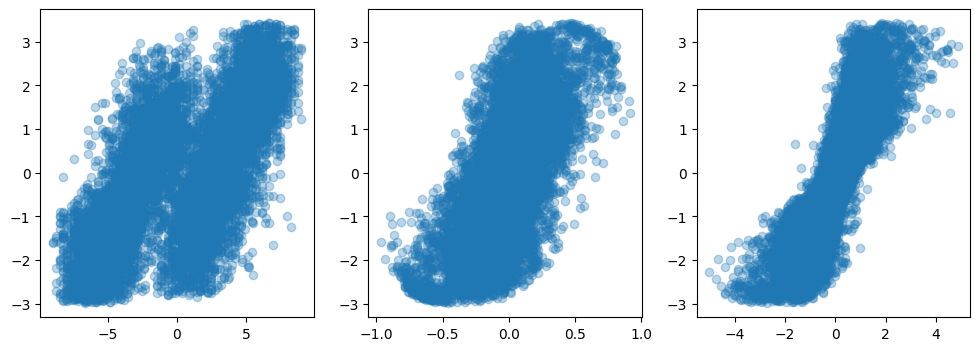

In [12]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X_test[:, 0] + X_test[:, 1] - X_test[:, 2] - X_test[:, 3], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.3);

plt.subplot(132)
plt.scatter(X_test[:, 4] + X_test[:, 5] - X_test[:, 6] - X_test[:, 7], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.3);

plt.subplot(133)
a1 = X_test[:, 0]*X_test[:, 4] +X_test[:, 1]*X_test[:, 5]
a2 = X_test[:, 2]*X_test[:, 6] +X_test[:, 3]*X_test[:, 7]
plt.scatter(a1 - a2, pred_v[:, 0] - pred_v[:, 1], alpha=0.3);

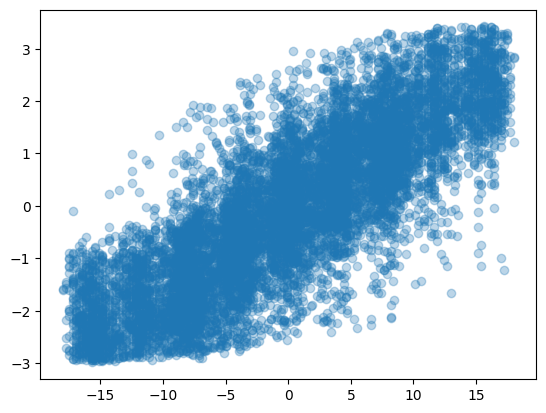

In [13]:
plt.scatter(4*X_test[:, 0] + X_test[:, 1] - 4*X_test[:, 2] - X_test[:, 3], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.3);